In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/PhysionetModels/Mimic_Data')

In [3]:
!ls

best.pth	       lab_data_10000_15000.csv  lab_data_30000_end.csv
death_labels_data.csv  lab_data_15000_20000.csv  lab_data_5000_10000.csv
death_meta_data.csv    lab_data_20000_25000.csv  variable_stats.csv
lab_data_0_5000.csv    lab_data_25000_30000.csv  variable_stats.gsheet


In [3]:
import pandas as pd
import numpy as np
# Load Dataset

file_paths=['lab_data_0_5000.csv','lab_data_5000_10000.csv','lab_data_10000_15000.csv','lab_data_15000_20000.csv','lab_data_20000_25000.csv','lab_data_25000_30000.csv','lab_data_30000_end.csv']


#dfs = [pd.read_csv(fp) for fp in file_paths]
#df_full = pd.concat(dfs, ignore_index=True)
#print("Total shape:", df_full.shape)  # should be (35000, 449)

#df_lab.fillna(0, inplace=True)


In [5]:
df1= pd.read_csv('lab_data_0_5000.csv')
df1.shape
#df1[df1['stay_id']== 32180361]

(240000, 847)

In [6]:
import pandas as pd
import numpy as np

def load_all_patient_series(file_paths):
    patient_series = {}
    for path in file_paths:
        print(f"Loading {path}")
        df = pd.read_csv(path)
        time_cols = df.columns.difference(['patientid', 'stay_id', 'date'])

        for sid, group in df.groupby('stay_id'):
            patient_series[sid] = group[time_cols].to_numpy()
    return patient_series



In [7]:
def load_labels(label_path):
    labels_df = pd.read_csv(label_path)
    labels_df.set_index('stay_id', inplace=True)
    return labels_df


In [8]:
def compute_missingness(patient_series):
    patient_ids = []
    patient_miss = []
    feature_miss = []

    for sid, arr in patient_series.items():
        mask = np.isnan(arr)
        patient_ids.append(sid)
        patient_miss.append(mask.mean())
        feature_miss.append(mask.mean(axis=0))  # mean per feature

    patient_miss_df = pd.DataFrame({
        'stay_id': patient_ids,
        'missing_pct': patient_miss
    }).set_index('stay_id')

    feature_miss_df = pd.DataFrame(feature_miss, index=patient_ids)
    mean_feature_miss = feature_miss_df.mean(axis=0)

    return patient_miss_df, mean_feature_miss


In [9]:
def select_subset(patient_series, patient_miss_df, feature_miss, x=2000, y=50, max_missing=0.7):
    # Step 1: Select best features
    selected_features = feature_miss.sort_values().index[:y]

    # Step 2: Filter patients based on missingness on selected features
    selected_patients = []
    for sid, data in patient_series.items():
        if sid not in patient_miss_df.index:
            continue
        sub_data = data[:, selected_features]
        if np.isnan(sub_data).mean() <= max_missing:
            selected_patients.append(sid)
        if len(selected_patients) >= x:
            break

    return selected_patients, selected_features


In [10]:
def build_final_dataset(patient_series, selected_patients, selected_features, labels_df, label_col='icu_death'):
    X = []
    y = []

    for sid in selected_patients:
        data = patient_series[sid][:, selected_features]
        X.append(data)
        y.append(labels_df.loc[sid][label_col])

    return np.stack(X), np.array(y)


In [ ]:
# Step 1
file_paths = ['lab_data_0_5000.csv','lab_data_5000_10000.csv','lab_data_10000_15000.csv']
patient_series = load_all_patient_series(file_paths)

# Step 2
labels_df = load_labels("death_labels_data.csv")
labels_df = labels_df.loc[labels_df.index.intersection(patient_series.keys())]

# Step 3
patient_miss_df, feature_miss = compute_missingness(patient_series)

# Step 4
selected_patients, selected_features = select_subset(
    patient_series, patient_miss_df, feature_miss,
    x=4000, y=64, max_missing=0.7
)

# Step 5
X, y = build_final_dataset(patient_series, selected_patients, selected_features, labels_df)

print(f"✅ Final X shape: {X.shape}  (patients × time × features)")
print(f"✅ Final y shape: {y.shape}")
print(f"✅ Missingness: {(np.isnan(X).sum() / X.size):.2%}")


Loading lab_data_0_5000.csv
Loading lab_data_5000_10000.csv
Loading lab_data_10000_15000.csv


In [ ]:
count = np.count_nonzero(X)
print(f"Number of non-zero values: {count}")


Number of non-zero values: 160987


In [ ]:
# one drop and make it 100 features
#df_lab = df_lab.drop(columns=['220181'])

In [ ]:
X = X.transpose(0, 2, 1)
X.shape

(4000, 64, 48)

In [ ]:
data=X
target=y

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_temp, y_train, y_temp = train_test_split(data, target, test_size=0.2, random_state=42, shuffle=False)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

### 4. Training a Sequence Model

#### 4.1 Data Preprocessing

This shows how the data can be split, prepared into a pytorch dataloader, and be used for a small pytorch model. The model itself is not competitive or "good", but is just a small example.

We split the data into train, validation, and test splits, using the "set" labels provided in the Physionet2012 challenge dataset. Any other split is also possible.

In [ ]:
!pip install torchinfo

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import TensorDataset, DataLoader
from torchinfo import summary
from sklearn.metrics import roc_auc_score, precision_recall_curve, accuracy_score, f1_score, auc, confusion_matrix


In [ ]:
x_train.shape

(3200, 64, 48)

In [ ]:
def reshape_to_6x6_tensor(x):
    # x shape: (n_samples, 36, 48)
    x = x.transpose(0, 2, 1)  # → (n_samples, 48, 36)
    x = x.reshape(x.shape[0], x.shape[1], 8, 8)  # → (n_samples, 48, 6, 6)
    x = x[:, :, None, :, :]  # → (n_samples, 48, 1, 6, 6)
    return x


In [ ]:
x_train = reshape_to_6x6_tensor(x_train)
x_val = reshape_to_6x6_tensor(x_val)
x_test = reshape_to_6x6_tensor(x_test)

In [ ]:
x_train.shape

(3200, 48, 1, 8, 8)

In [ ]:
x_train = np.transpose(x_train, (0, 2, 1, 3, 4))
x_val = np.transpose(x_val, (0, 2, 1, 3, 4))
x_test = np.transpose(x_test, (0, 2, 1, 3, 4))

In [ ]:
# 2. Convert to tensors
trn_ds = TensorDataset(torch.tensor(x_train).float(), torch.tensor(y_train).long())
val_ds = TensorDataset(torch.tensor(x_val).float(), torch.tensor(y_val).long())
tst_ds = TensorDataset(torch.tensor(x_test).float(), torch.tensor(y_test).long())

In [ ]:
x_train.shape, y_train.shape


((3200, 1, 48, 8, 8), (3200,))

In [ ]:
# 3. Create data loaders
trn_dl = DataLoader(trn_ds, batch_size=256, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=256, shuffle=False)
tst_dl = DataLoader(tst_ds, batch_size=256, shuffle=False)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# === ℓ₁−ℓ₂ Penalty ===
class PermutationL1L2Penalty(nn.Module):
    def forward(self, M):
        row_l1 = M.abs().sum(dim=-1)
        row_l2 = torch.sqrt((M ** 2).sum(dim=-1) + 1e-6)
        col_l1 = M.abs().sum(dim=-2)
        col_l2 = torch.sqrt((M ** 2).sum(dim=-2) + 1e-6)
        penalty = (row_l1 - row_l2).sum(dim=-1) + (col_l1 - col_l2).sum(dim=-1)
        return penalty.mean()

# === Row and Column Normalization (Single Iteration)  ===
def normalize_once(M):
    M = M.clamp(min=1e-6)  # Ensure non-negativity
    M = M / M.sum(dim=0, keepdim=True)  # Column normalization
    M = M / M.sum(dim=1, keepdim=True)  # Row normalization
    return M

# === Permutation Layer with L1-L2 Regularization ===
class Permutation3DLayer(nn.Module):
    def __init__(self, num_features=36):
        super().__init__()
        self.num_features = num_features
        self.perm_matrix = nn.Parameter(torch.abs(torch.randn(num_features, num_features)))
        self.penalty_fn = PermutationL1L2Penalty()
        self.last_penalty = torch.tensor(0.0)
        self.fixed_perm_matrix = None


    def forward(self, x):
        B, C, T, H, W = x.shape
        x_seq = x.view(B, T, H*W)  # Flatten: (B, 48,36)

        if self.fixed_perm_matrix is not None:
            M = self.fixed_perm_matrix.to(x.device)
        else:
            M = normalize_once(self.perm_matrix)
            self.last_penalty = self.penalty_fn(M)


        x_perm = torch.bmm(x_seq, M.T.expand(B, -1, -1))
        return x_perm.view(B, C, T, H, W)

# === Custom Conv3D Block ===
class CostumConv3d(nn.Module):
    def __init__(self, ni, no, kernel, stride, pad, drop=None, activ=lambda: nn.ReLU(inplace=True)):
        super().__init__()
        layers = [nn.Conv3d(ni, no, kernel, stride, pad)]
        if activ:
            layers.append(activ())
        if drop is not None:
            layers.append(nn.Dropout3d(drop))  # 3D Dropout for consistency
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

# === Flatten Layer ===
class Flatten(nn.Module):
    def __init__(self, keep_batch_dim=True):
        super().__init__()
        self.keep_batch_dim = keep_batch_dim

    def forward(self, x):
        if self.keep_batch_dim:
            return x.view(x.size(0), -1)
        return x.view(-1)

# === Final Classifier ===
class Classifier(nn.Module):
    def __init__(self, raw_ni=None, no=2, drop=0.5):
        super().__init__()

        self.permute = Permutation3DLayer(num_features=64)

        self.conv_block = nn.Sequential(
            CostumConv3d(1, 16, kernel=(48, 3, 3), stride=1, pad=1, drop=drop),
            CostumConv3d(16, 32, kernel=(3, 3, 3), stride=1, pad=1, drop=drop),
            nn.AdaptiveAvgPool3d((1, 1, 1))  # → (batch, 32, 1, 1, 1)
        )

        self.flatten = Flatten()

        self.fc = nn.Sequential(
            nn.Linear(32, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, no)
        )

    def forward(self, t_raw):
        # t_raw shape: (batch, 1, 48, 6, 6)
        x = self.permute(t_raw)
        x = self.conv_block(x)  # → (batch, 32, 1, 1, 1)
        x = self.flatten(x)     # → (batch, 32)
        return self.fc(x)


In [ ]:
for epoch in range(1):
    epoch_loss = 0
    for i, batch in enumerate(trn_dl):
        x_raw, y_batch = [t.to(device) for t in batch]
x_raw.shape,y_batch.shape


(torch.Size([128, 1, 48, 8, 8]), torch.Size([128]))

In [ ]:
num_classes = 2
drop = 0.3
loss_history = []
acc_history = []
val_losses = []
patience, trials = 10, 0
base, step = 1, 2
best_acc = 0
n_epochs = 100
lambda_ = 1e-2


model = Classifier(no=num_classes, drop=drop).to(device)
criterion = nn.CrossEntropyLoss(torch.tensor([1.0, 6.0]).to(device)) #Compares predicted logits (before softmax) to true labels
opt = optim.Adam(model.parameters(), lr=0.001)


# Example pass-through for shape check
x_dummy = torch.randn(1,1,48,8,8).to(device)
print("Dummy input shape:", x_dummy.shape)
with torch.no_grad():
    print("Output shape:", model(x_dummy).shape)

model = Classifier(no=num_classes, drop=drop).to(device)
class_weights = torch.tensor([1.0, 6.0]).to(device)
criterion = nn.CrossEntropyLoss(class_weights)
opt = optim.Adam(model.parameters(), lr=0.001)

print('Start model training')



Dummy input shape: torch.Size([1, 1, 48, 8, 8])
Output shape: torch.Size([1, 2])
Start model training


In [ ]:
for epoch in range(1, n_epochs + 1):
    model.train()
    epoch_loss = 0
    perm_penalty_epoch = 0

    for x_raw, y_batch in trn_dl:
        x_raw, y_batch = x_raw.to(device), y_batch.to(device)
        opt.zero_grad()

        out = model(x_raw)
        perm_penalty = model.permute.last_penalty  # after forward()
        ce_loss = criterion(out, y_batch)
        loss = ce_loss + lambda_ * perm_penalty

        loss.backward()
        opt.step()

        epoch_loss += loss.item()
        perm_penalty_epoch += perm_penalty.item()

    epoch_loss /= len(trn_dl)
    perm_penalty_epoch /= len(trn_dl)
    loss_history.append(epoch_loss)

    print(f"Epoch: {epoch:3d}. Loss: {epoch_loss:.4f}. Permutation Penalty: {perm_penalty_epoch:.4f}")

    # Validation
    model.eval()
    correct, all_probs, all_labels = 0, [], []
    val_loss = 0

    with torch.no_grad():
        for x_raw, y_batch in val_dl:
            x_raw, y_batch = x_raw.to(device), y_batch.to(device)
            out = model(x_raw)
            probs = F.softmax(out, dim=1)[:, 1]
            preds = (probs > 0.5)
            correct += (preds == y_batch).sum().item()
            all_probs.append(probs.cpu())
            all_labels.append(y_batch.cpu())


            ce_loss_val = criterion(out, y_batch)
            perm_penalty_val = model.permute.last_penalty
            loss_val = ce_loss_val + lambda_ * perm_penalty_val
            val_loss += loss_val.item()

    val_loss /= len(val_dl)
    val_losses.append(val_loss)

    acc = correct / len(val_dl.dataset)
    acc_history.append(acc)
    auc_score = roc_auc_score(torch.cat(all_labels), torch.cat(all_probs))

    print(f"Epoch: {epoch:3d}. Acc.: {acc:.2%}. AUC: {auc_score:.4f}")

    if acc > best_acc:
        best_acc = acc
        trials = 0
        torch.save(model.state_dict(), "best.pth")
        print(f"✓ Saved best model at epoch {epoch} with accuracy {acc:.2%}")
    else:
        trials += 1
        if trials >= patience:
            print("Early stopping.")
            break

print("Done!")

Epoch:   1. Loss: 1.7672. Permutation Penalty: 107.5611
Epoch:   1. Acc.: 93.50%. AUC: 0.6750
Early stopping.
Done!


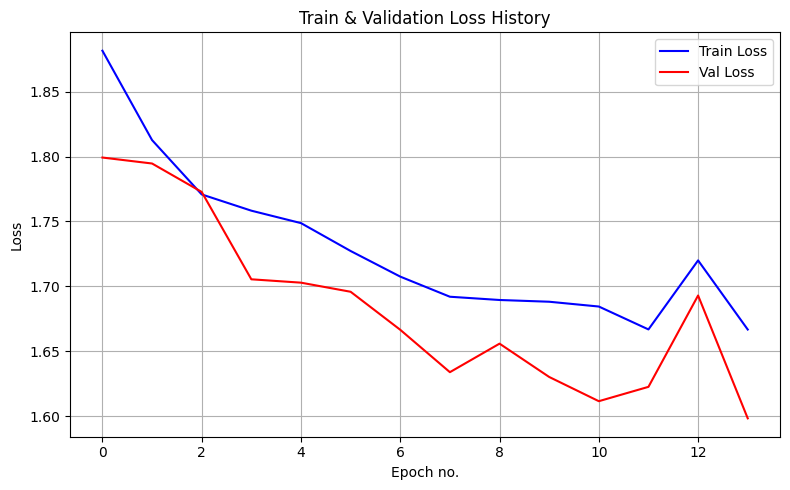

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label='Train Loss', color='blue')
plt.plot(val_losses, label='Val Loss', color='red')
plt.title('Train & Validation Loss History')
plt.xlabel('Epoch no.')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
preds_array = np.array([])
for batch in tst_dl:
        x_raw, y_batch = [t.to(device) for t in batch]
        out = model(x_raw)
        preds = F.log_softmax(out, dim=1).argmax(dim=1).cpu().numpy()
        preds_array = np.concatenate((preds_array, preds), axis=None)

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, auc,
    f1_score, accuracy_score, confusion_matrix
)

def evaluate_binary_classification(model, dataloader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """Evaluation metrics for binary classification using a PyTorch DataLoader."""
    model.eval()
    probs_list, labels_list = [], []

    with torch.no_grad():
        for x_raw, y_batch in dataloader:
            x_raw = x_raw.to(device)
            logits = model(x_raw)
            probs = F.softmax(logits, dim=1).cpu().numpy()
            probs_list.append(probs)
            labels_list.append(y_batch.cpu().numpy())

    predicted_proba_long = np.vstack(probs_list)
    y_true_long = np.concatenate(labels_list)
    predicted_label_long = predicted_proba_long.argmax(axis=1)

    # Metrics
    roc_auc_result = roc_auc_score(y_true_long, predicted_proba_long[:, 1])
    precision, recall, thresholds = precision_recall_curve(y_true_long, predicted_proba_long[:, 1])
    pr_auc_result = auc(recall, precision)
    f1_result = f1_score(y_true_long, predicted_label_long)
    accuracy_result = accuracy_score(y_true_long, predicted_label_long)

    # Print output exactly like your original style
    print(
        f"roc_auc_result: {roc_auc_result:.5f}\n"
        f"pr_auc_result: {pr_auc_result:.5f}\n"
        f"f1_result: {f1_result:.5f}\n"
        f"accuracy_result: {accuracy_result:.5f}"
    )
    print("Confusion matrix:\nTN FP\nFN TP")
    print(confusion_matrix(y_true_long, predicted_label_long))

In [ ]:
# Uncomment to use soft permutation instead of hard
model.load_state_dict(torch.load("best.pth"))
model.permute.fixed_perm_matrix = None
evaluate_binary_classification(model, tst_dl)

roc_auc_result: 0.61982
pr_auc_result: 0.15589
f1_result: 0.00000
accuracy_result: 0.91250
Confusion matrix:
TN FP
FN TP
[[365   1]
 [ 34   0]]
